![](https://i.imgur.com/qkg2E2D.png)

# UnSupervised Learning Methods

## Exercise 003 - Part III

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 23/05/2023 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/UnSupervisedLearningMethods/2023_03/Exercise0002Part002.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_openml, load_breast_cancer, load_digits, load_iris, load_wine, make_s_curve

# Computer Vision

# Miscellaneous
import os
import math
from platform import python_version
import random
import time
import urllib.request

# Typing
from typing import Callable, List, Tuple, Union

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image, display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout


from scipy.spatial.distance import cdist


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

In [2]:
# Configuration
%matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [3]:
# Constants

DATA_FILE_URL   = r'None'
DATA_FILE_NAME  = r'None'

T_MNIST_IMG_SIZE = (28, 28)


In [4]:
# Auxiliary Functions

def BalancedSubSample( dfX: pd.DataFrame, colName: str, numSamples: int ):
    
    # TODO: Validate the number of samples
    # TODO: Validate the column name (Existence and categorical values)
    return dfX.groupby(colName, as_index = False, group_keys = False).apply(lambda dfS: dfS.sample(numSamples, replace = False))

## Guidelines

 - Fill the full names and ID's of the team members in the `Team Members` section.
 - Answer all questions / tasks within the Jupyter Notebook.
 - Use MarkDown + MathJaX + Code to answer.
 - Verify the rendering on VS Code.
 - Submission in groups (Single submission per group).
 - You may and _should_ use the forums for questions.
 - Good Luck!

* <font color='brown'>(**#**)</font> The `Import Packages` section above imports most needed tools to apply the work. Please use it.
* <font color='brown'>(**#**)</font> You may replace the suggested functions to use with functions from other packages.
* <font color='brown'>(**#**)</font> Whatever not said explicitly to implement maybe used by a 3rd party packages.
* <font color='brown'>(**#**)</font> The total run time of this notebook must be **lower than 60 [Sec]**.

## Generate / Load Data

In [5]:
# Download Data
# This section downloads data from the given URL if needed.

if (DATA_FILE_NAME != 'None') and (not os.path.exists(DATA_FILE_NAME)):
    urllib.request.urlretrieve(DATA_FILE_URL, DATA_FILE_NAME)

## 3. Kernel PCA (K-PCA / KPCA)

### 3.1. Kernel PCA Algorithm

In this section we'll implement a SciKit Learn API compatible class for the Kernel PCA.  
The class should implement the following methods:

1. `__init____()` - The object constructor by the encoder dimension.  
   The input will include the encoder dimension `d` and a callable function for the kernel.
2. `fit()` - Given a data set builds the encoder.  
3. `transform()` - Applies the encoding on the input data.   

* <font color='brown'>(**#**)</font> You may use the [SciKit Learn's Kernel PCA module](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) as a reference.
* <font color='brown'>(**#**)</font> Both encoding and decoding applied as out of sample encoding / decoding.
* <font color='brown'>(**#**)</font> Pay attention to data structure (`N x D`).
* <font color='brown'>(**#**)</font> You may assume the kernel function `k` ($ k : \, \mathbb{R}^{D} \times \mathbb{R}^{D} \to \mathbb{R} $) has the following signature:

```python
def k(mX1: np.ndarray, mX2: np.ndarray)
    '''
    Computes the kernel function between two sets of vectors.
    Args:
        mX1 - Input data with shape N1 x D.
        mX2 - Input data with shape N2 x D.
    Output:
        mKx - Output kernel matrix with shape N1 x N2.
    '''
```


In [6]:
class KPCA:
    def __init__(self, d: int = 2, k: Callable = lambda x: x):
        '''
        Constructing the object.
        Args:
            d - Number of dimensions of the encoder output.
            k - A kernel function (Callable).
        '''
        #===========================Fill This===========================#
        # 1. Keep the model parameters.

        self.d      = d
        self.k_func = k
         
        #===============================================================#
        
    def fit(self, mX: np.ndarray):
        '''
        Fitting model parameters to the input.
        Args:
            mX - Input data with shape N x D.
        Output:
            self
        '''
        #===========================Fill This===========================#
        # 1. Build the model encoder.
        # 2. Optimize calculation by the dimensions of `mX`.
        # !! You may find `scipy.sparse.linalg.svds()` useful.
        # !! You may find `scipy.sparse.linalg.eigsh()` useful.
        # Do not use `J` explicitly as a matrix multiplication.
        
        # Note. The suffix m is used to chage the matrix dimension to the math oriantation
        # Sometimes we preform twice transform and this is unecessarey. Hower it is for better code redability compared to the math
        mX_m  = mX.T   # D*N
        
        #############################
        # Dual implementation D>N ##
        ############################
        
        #Calculate the kernel function
        self.k_big  = self.k_func(mX_m , mX_m)  # results N*N  for dual we need kernel of mX_m.T @ mX_m

        k_big1      = self.k_big - self.k_big.mean(axis = 1).reshape(-1,1)
        k_big2      = k_big1 - k_big1.mean(axis = 0).reshape(1,-1)
        s2, v       = sp.sparse.linalg.eigsh(k_big2 , k=self.d , which='LM' , return_eigenvectors=True)
        s2          = s2[::-1]
        v           = v[:,::-1]

        s_inv             =  1/np.sqrt(s2)
        s_inv_matrix = np.eye(self.d)*s_inv.reshape(-1,1)
        
        self.term1 = np.matmul(s_inv_matrix , v.T ) # Store for later OOS
        
        self.mX    = mX_m  # Store for later OOS

        #===============================================================# 
        return self
    
    def transform(self, mX: np.ndarray) -> np.ndarray:
        '''
        Applies (Out of sample) encoding
        Args:
            mX - Input data with shape N x D.
        Output:
            mZ - Low dimensional representation (embeddings) with shape N x d.
        '''
        #===========================Fill This===========================#
        # 1. Encode data using the model encoder.
        
        mX_m = mX.T   # D*N
                
        k_small    = self.k_func(self.mX ,  mX_m)           # for dual mX_m.T @ mX_m
        
        tmp1       = (k_small -  self.k_big.mean(axis = 1).reshape(-1,1)  )

        k_small_center  = tmp1 - tmp1.mean(axis = 0).reshape(1,-1)
 
        mZ_m   = np.matmul(self.term1 , k_small_center)
        
        mZ     = mZ_m.T
        
        #===============================================================#

        return mZ
    


* <font color='red'>(**?**)</font> Why `inverse_transform()` is not implemented? You may read about SciKit Learn's `inverse_transform()`.

### 4.2. K-PCA Application

In this section the K-PCA (Using the above class) will be applied on several data sets:

 * Breast Cancer Dataset - Loaded using `load_breast_cancer()`.
 * Digits Dataset - Loaded using `load_digits()`.
 * Iris Dataset - Loaded using `load_iris()`.
 * Wine Dataset - Loaded using `load_wine()`.

For each data set:

1. Make yourself familiar with the data set:
    * How many features are there ($D$).
    * How many samples are there ($D$).
    * Do all features have the same unit?
2. Apply a Pre Process Step  
   In ML, usually, if the features do not have the same unit they are normalized.  
   Namely, make each feature with zero mean and unit standard deviation.   
   Write a function to normalize input data.
3. Apply the K-PCA  
   Set `d` to be visualization friendly and apply PCA from $D$ to $d$.  
   The obtained the low dimensional data represents $\boldsymbol{Z} \in \mathbb{R}^{d \times N}$.  
   You should use the following kernels (Implemented by yourself):
     * $k \left( \boldsymbol{x}_{i}, \boldsymbol{x}_{j} \right) = \boldsymbol{x}_{i}^{T} \boldsymbol{x}_{j}$.
     * $k \left( \boldsymbol{x}_{i}, \boldsymbol{x}_{j} \right) = \left(1 + \boldsymbol{x}_{i}^{T} \boldsymbol{x}_{j} \right)^{p}$.  
       You should set a reasonable $p$.
     * $k \left( \boldsymbol{x}_{i}, \boldsymbol{x}_{j} \right) = \exp \left( - \frac{\left\| \boldsymbol{x}_{i} - \boldsymbol{x}_{j} \right\|_{2}^{2}}{2 {\sigma}^{2}} \right)$.  
       You should set a reasonable $\sigma$.
4. Plot Low Dimensional Data  
   Make a scatter plot of $\boldsymbol{Z} \in \mathbb{R}^{d \times N}$ and color the data points according to the data labels.  
   For each data set show result with the normalization step and without it.


* <font color='brown'>(**#**)</font> Pay attention to the difference in dimensions of the data to the derived Math formulations.
* <font color='brown'>(**#**)</font> The output should be 2 figures for each data set and kernel. You may show them in a single plot using sub plots.

In [7]:
#===========================Fill This===========================#
# 1. Implement the normalization function.
# !! Make sure to address the remark.

def NormalizeData(mX: np.ndarray) -> np.ndarray:
    '''
    Normalize data so each feature has zero mean and unit standard deviation.
    Args:
        mX  - Input data with shape N x d.
    Output:
        mY  - Output data with shape N x d.
    Remarks:
        - Features with zero standard deviation are not scaled (Only centered).
    '''

    MU    = mX.mean(axis = 0).reshape(1,-1)
    STD   = mX.std(axis = 0).reshape(1,-1)
    
    f_zero_std_idx = (STD == 0).ravel()
    
    mY = np.empty_like(mX)
    
    mY[:,f_zero_std_idx]     = (mX[:,f_zero_std_idx]  - MU[:,f_zero_std_idx]) 
    mY[:,~f_zero_std_idx]    = (mX[:,~f_zero_std_idx] - MU[:,~f_zero_std_idx]) / STD[:,~f_zero_std_idx]

    return mY 
#===============================================================#

In [8]:
#===========================Fill This===========================#
# 1. Implement the 3 kernels.
# !! Make sure to address the remarks.
# !! Pay attention that `np.dot(mA.T, mA)` is faster (Symmetric aware) than `mA.T @ mA`.

def KernelInnerProduct( mX1: np.ndarray, mX2: np.ndarray ) -> np.ndarray:
    '''
    Calculates the kernel matrix of the Inner Product kernel.
    Args:
        mX1 - Input data with shape N1 x D.
        mX2 - Input data with shape N2 x D.
    Output:
        mKx - Output data with shape N1 x N2.
    Remarks:
        - The function is implemented without explicit loops.
    '''

    mKx = np.dot(mX1.T , mX2)
    return mKx

def KernelPolynomial( mX1: np.ndarray, mX2: np.ndarray, p: int = 2 ) -> np.ndarray:
    '''
    Calculates the kernel matrix of the Polynomial kernel.
    Args:
        mX1 - Input data with shape N1 x D.
        mX2 - Input data with shape N2 x D.
        p   - The degree of the model.
    Output:
        mKx - Output data with shape N1 x N2.
    Remarks:
        - The function is implemented without explicit loops.
    '''

    mKx = (1+np.dot(mX1.T , mX2))**p 
    return mKx

def KernelGaussian( mX1: np.ndarray, mX2: np.ndarray, σ2: float = None ) -> np.ndarray:
    '''
    Calculates the kernel matrix of the Gaussian kernel.
    Args:
        mX1 - Input data with shape N1 x D.
        mX2 - Input data with shape N2 x D.
        σ2  - The variance of the model.
    Output:
        mKx - Output data with shape N1 x N2.
    Remarks:
        - The function is implemented without explicit loops.
    '''
    # NOTE !!!
    # Need transform input  as cdist works on rows and we need columns
    # Why we need columns ? -> Although in the header of the function  it is written thay mX is N*D actually 
    # we get D*N as we do transpose in the KPCA fit function.  
    # All is to  be align with the math formulas.... 
    # Bottom line need to change this header function to be D*N and then everythin is clear 
    dist_mat = cdist(mX1.T , mX2.T, metric='euclidean') 
    
    mKx = np.exp(-dist_mat**2/(2*(σ2**2)) )
    
    return mKx

#===============================================================#

In [9]:
#===========================Fill This===========================#
# 1. Set parameter `d`.
# 2. Load each data set.
# 3. Apply PCA to each data set with and without normalization.
# 4. Display results as scatter data.

In [33]:
# Data sets 
dataset_list = [load_breast_cancer, load_digits, load_iris, load_wine] 

data_dict = {}
for data_load_func in dataset_list:  # make_s_curve
    name = name = "_".join(data_load_func.__name__.split("_")[1::]) # removes the load .could also use regexp....
    data_dict[name] = {}
    data_dict[name]['data'] , data_dict[name]['label'] = data_load_func(return_X_y=True , as_frame=False)
    data_dict[name]['data_norm']  = NormalizeData(data_dict[name]['data'])
    print (name)
    print ("Samples: {} , Features: {}   classes: {}\n". \
           format(data_dict[name]['data'].shape[0],data_dict[name]['data'].shape[1] ,\
                  np.unique(data_dict[name]['label']).size ))

# Kernels to use 
p_poly_dict = {}
p_poly_dict['breast_cancer'] = 1
p_poly_dict['digits']        = 1
p_poly_dict['iris']          = 1
p_poly_dict['wine']          = 1

rbf_σ2_dict = {}
rbf_σ2_dict['breast_cancer'] = 5
rbf_σ2_dict['digits']        = 20   #3
rbf_σ2_dict['iris']          = 0.5
rbf_σ2_dict['wine']          = 5


breast_cancer
Samples: 569 , Features: 30   classes: 2

digits
Samples: 1797 , Features: 64   classes: 10

iris
Samples: 150 , Features: 4   classes: 3

wine
Samples: 178 , Features: 13   classes: 3



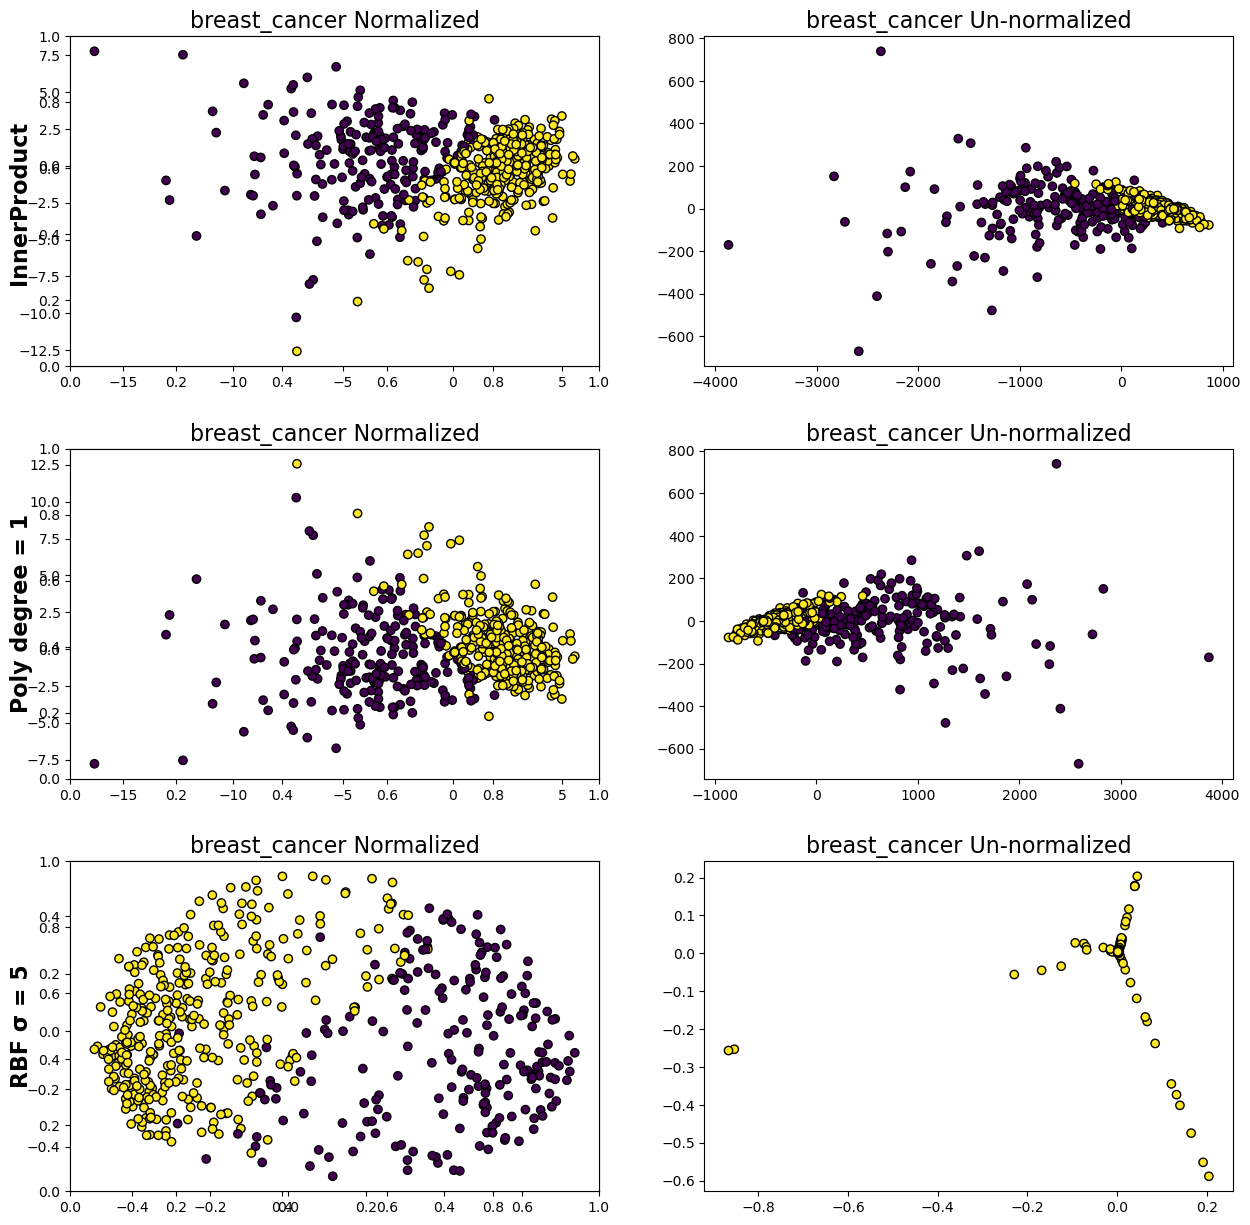

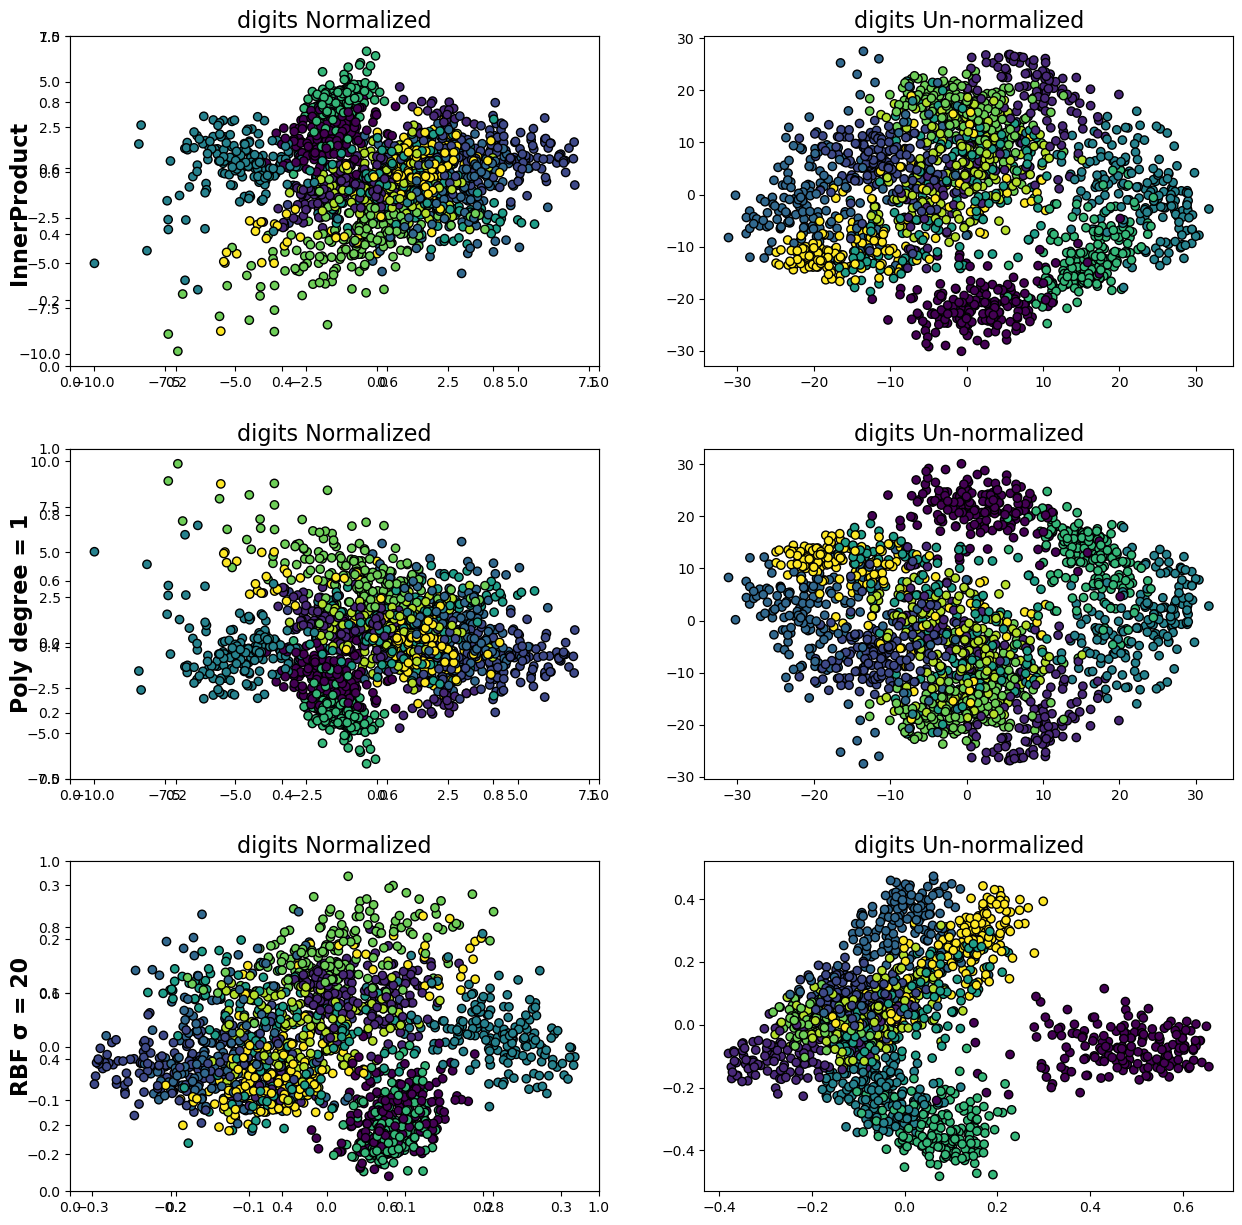

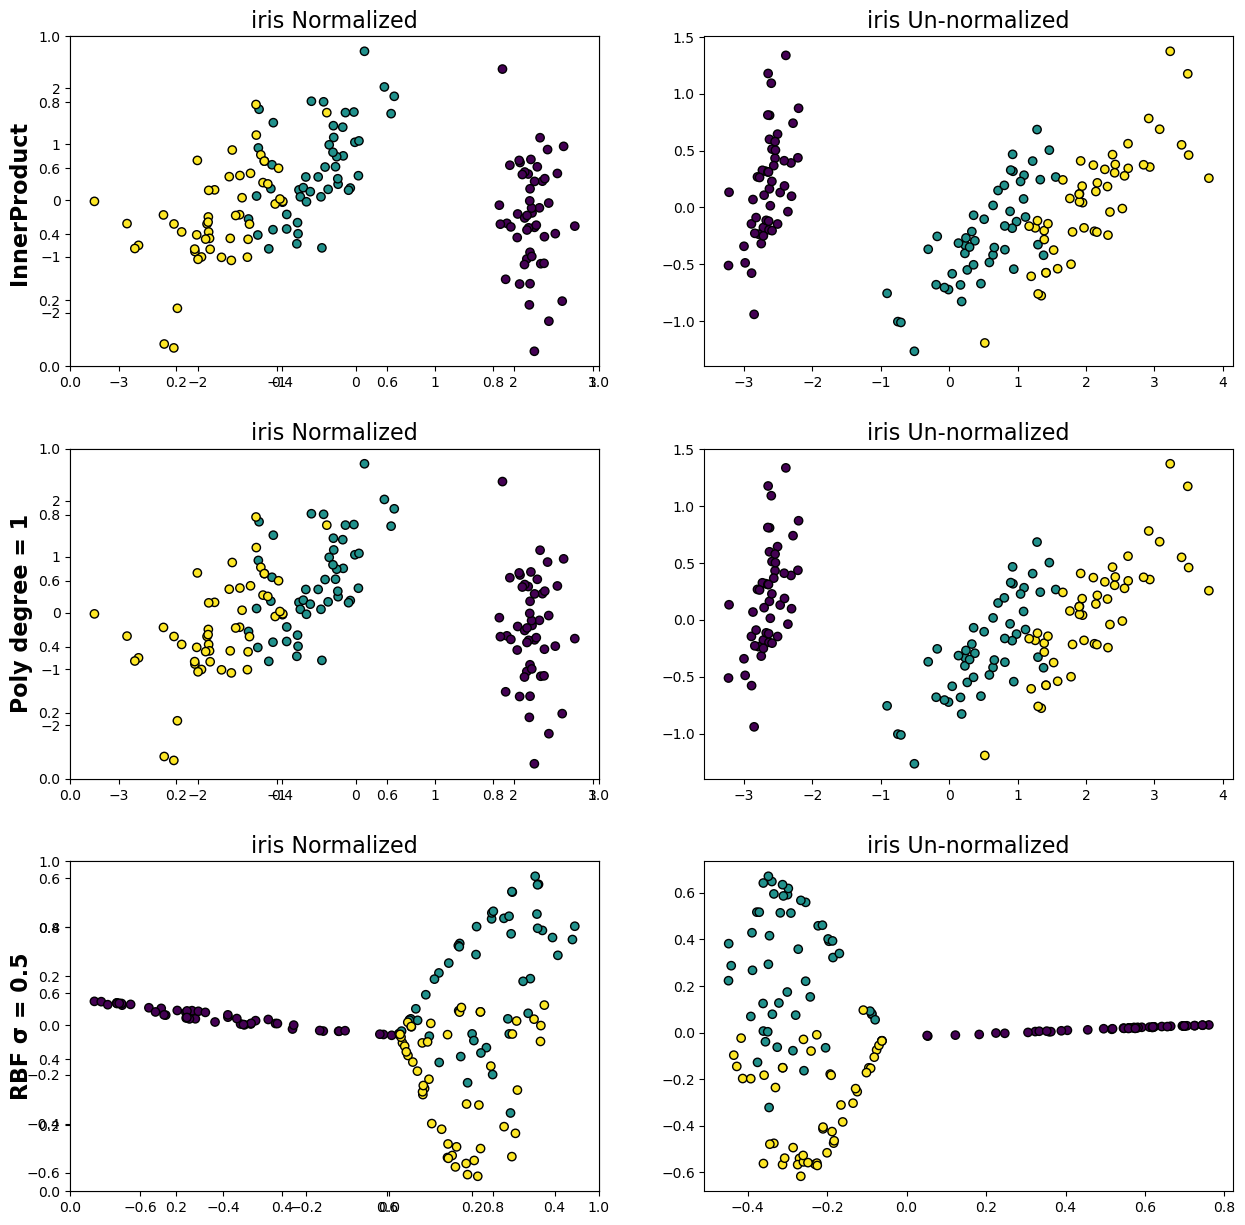

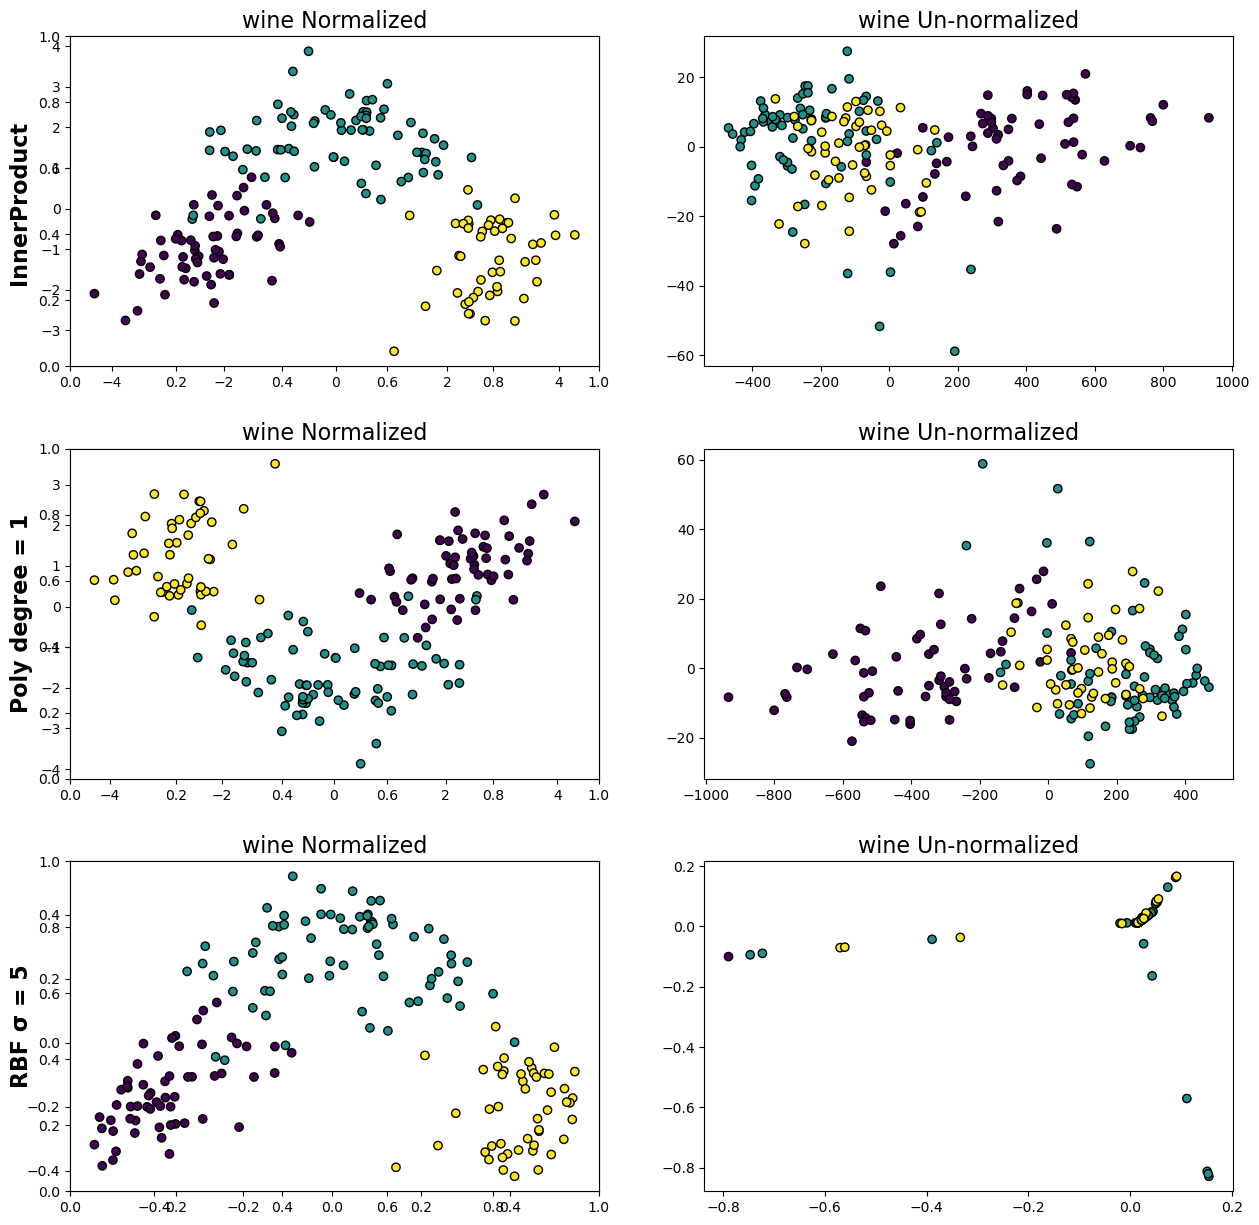

In [34]:
d = 2

for  (dataset_name , dataset_values) in  data_dict.items():
    mX      = data_dict[dataset_name]['data']
    mX_norm = data_dict[dataset_name]['data_norm']
    y       = data_dict[dataset_name]['label']
    
    # Kernels to use 
    p_poly       = p_poly_dict[dataset_name]
    rbf_σ2       = rbf_σ2_dict[dataset_name]
    k_func_Poly  = lambda mX1 , mX2 :  KernelPolynomial(mX1 , mX2 , p=p_poly) 
    k_func_rbf   = lambda mX1 , mX2 :  KernelGaussian(mX1 , mX2 , σ2=rbf_σ2) 
    k_func_list  = [KernelInnerProduct , k_func_Poly , k_func_rbf]
    k_name_list  = ['InnerProduct' , 'Poly' , 'RBF']
    
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(hspace=.25, wspace=.2)
    

    for k_num , k_func in enumerate(k_func_list):
        kernel_pca = KPCA(d = d , k = k_func)
        # un normalized data
        kernel_pca.fit(mX)
        z = kernel_pca.transform(mX)
                
        #  normalized data
        kernel_pca.fit(mX_norm)
        z_norm = kernel_pca.transform(mX_norm)
    
        fig_num  = (k_num)*2 + 1
        ax       = fig.add_subplot(len(k_func_list), 2, fig_num)
        if k_name_list[k_num] == 'Poly': 
            kernel_param = f'degree = {p_poly}'
        elif k_name_list[k_num] == 'RBF': 
            kernel_param = f'σ = {rbf_σ2}'
        else:
            kernel_param = ''
    
        ax.set_ylabel(f'{k_name_list[k_num]} {kernel_param}', fontsize=16,fontweight="bold")
      
        ax       = fig.add_subplot(len(k_func_list), 2, fig_num)
        ax.set_title(f'{dataset_name} Normalized', fontsize=16, ha="center" )
        ax.scatter(z_norm[:, 0], z_norm[:, 1], c = y, edgecolor = 'k')
    
        fig_num  = (k_num)*2 + 2
        ax       = fig.add_subplot(len(k_func_list), 2, fig_num)   
        ax.set_title(f'{dataset_name} Un-normalized', fontsize=16, ha="center" )
        ax.scatter(z[:, 0], z[:, 1], c = y, edgecolor = 'k')
    
    
#===============================================================#

### 4.3. Question

<b>In the above, compare the results of the _Inner Product_ kernel to the PCA from the previous part.  
Explain the results.

Inner Product Kernel is a linear kernel hence the results of regualr PCA and KPCA where Kernel is linear are exactly the same

We have tailored the various  kernels parameters for the various datasets  
It seems that poly kernel does not do great job in seperation (we know the lables...) hence selected poly degree = 1 whch is  linear kernel . For RBF controlling the practical number of dimensions (higher sigma less prctical dimensions) results by better seperation of the data in 2 dimensions.  

Note that if the features have aready the same scale we should avoid scaling.  it is o.k that the selected PCs are affected by features with high variance. Scaling is preformed  to avoid the effect of a feature with high variance due to its absolute big values. If PCA would would have used correlation instead of covariance matrix, then there would not be an issue as correlations is scaled.  In our case we shoulds avoid scaling for the digits datasert as all features are ofthe same scale.  =Hence we tried toselect the kernel parameters for digits based on the unnormalized dataset 

### 4.4. Kernel PCA with Geodesic Distance (Bonus 4 Points)

In this question we'll build a pseudo _geodesic distance_ and apply the Kernel PCA.

In this section:

 1. Generate 750 samples of S Curve manifold (2D in 3D) using SciKit Learn's [`make_s_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_s_curve.html).  
    Make sure to read about its output, specifically `t`.    
    This is already implemented.
 2. Build a pair wise distance function utilizing both the data coordinates and the `vT` variable.  
    Since the `vT` variable holds location data, this is a geodesic like distance.
 3. Show the distance for 3 different points.  
    This is already implemented.
 4. Apply a Kernel PCA from 3D to 2D on the data utilizing the distance function.
 5. Show the results in the 2D space.
 6. Explain the results (In words).

* <font color='brown'>(**#**)</font> Since in the case above we use a pre computed distance function, you may not use the K-PCA but the PCA. You may use SciKit's Learn PCA or your own implemen.ntatio
* With some tweaking of parameters and the distance function one may get the following result:

![](https://i.imgur.com/CYVzYnF.png)

In [20]:
# Generate the Data

N      = 750
mX, vT = make_s_curve(N)

numDispPts = 4

print(f'The data has shape of {mX.shape}')

The data has shape of (750, 3)


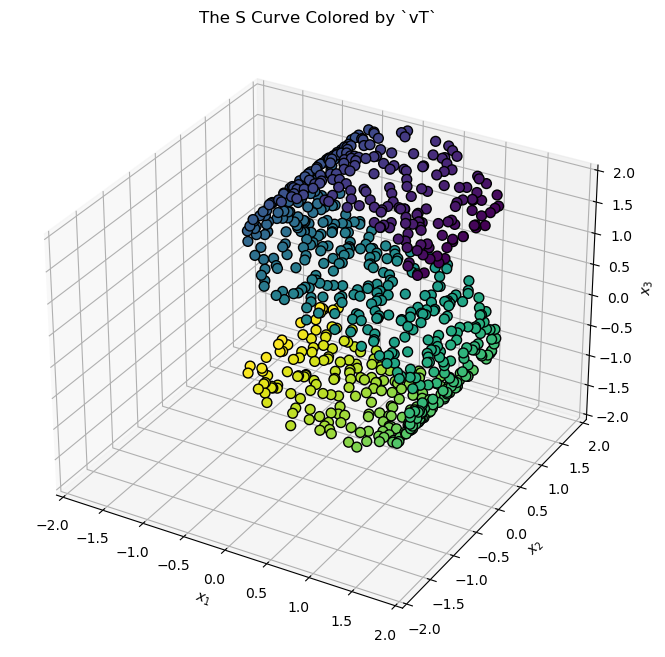

In [21]:
# Display the Data

hF = plt.figure(figsize = (8, 8))
hA = hF.add_subplot(projection = '3d')
hA.scatter(mX[:, 0], mX[:, 1], mX[:, 2], s = 50, c = vT, edgecolor = 'k', alpha = 1)

hA.set_xlim([-2, 2])
hA.set_ylim([-2, 2])
hA.set_zlim([-2, 2])
hA.set_xlabel('$x_1$')
hA.set_ylabel('$x_2$')
hA.set_zlabel('$x_3$')
hA.set_title('The S Curve Colored by `vT`')
plt.show()

In [35]:
#===========================Fill This===========================#
# 1. Generate a pair wise distance function.
# !! You may and should utilize the parameter `vT`.
# !! Since we use the location data `vT` this is a geodesic like distance.
# !! You may add any parameters you need to the function.

def DistanceFunction( mX: np.ndarray, vT: np.ndarray) -> np.ndarray:
    '''
    Calculates the kernel matrix of the Polynomial kernel.
    Args:
        mX - Input data with shape N x D.
        vT - Input data (Location)
    Output:
        mD - Pair wise distance matrix with shape N x N.
    Remarks:
        - You may use SciPy's `cdist()` and / or `pdist()`.
    '''
    data = np.concatenate((vT.reshape(-1,1) , mX[:,1].reshape(-1,1)) , axis = 1 )
        
    
    mD = cdist(data , data, metric='euclidean') # Note:  cdist works on rows

#===============================================================#
    
    return mD

In [36]:
#===========================Fill This===========================#
# 1. Calculate the Distance Matrix `mD`.
# !! You may add any parameters you need to the function.

mD = DistanceFunction(mX, vT )

#===============================================================#

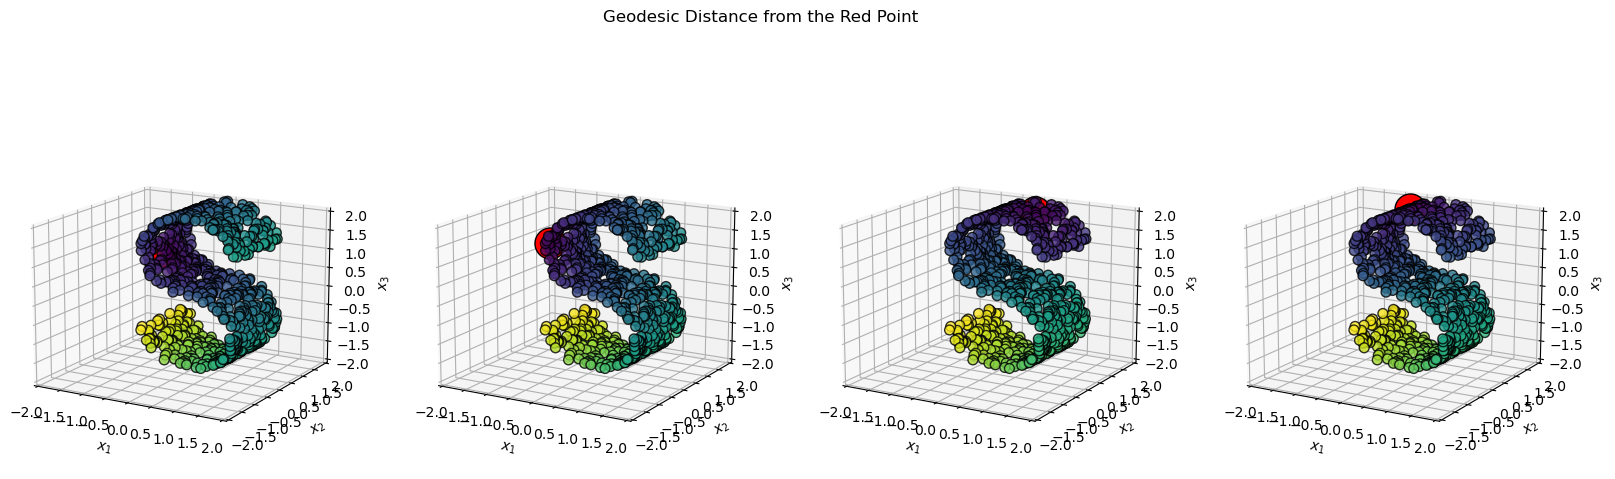

In [37]:
# Display the Distance Function for few Points
# The result should look like a local distance along the surface of the S curve.

vIdx = np.random.choice(N, numDispPts, replace = False)

hF = plt.figure(figsize = (20, 6))

for ii, idx in enumerate(vIdx):
    
    hA  = hF.add_subplot(1, numDispPts, ii + 1, projection = '3d')
    hA.scatter(*mX.T, s = 50, c = mD[idx, :], edgecolor = 'k', alpha = 0.8)
    hA.scatter(*mX[idx], s = 500, c = 'r', edgecolor = 'k', alpha = 1)
    hA.set_xlim([-2, 2])
    hA.set_ylim([-2, 2])
    hA.set_zlim([-2, 2])
    hA.set_xlabel('$x_1$')
    hA.set_ylabel('$x_2$')
    hA.set_zlabel('$x_3$')
    
    hA.view_init(elev = 15, azim = 300)

hF.suptitle('Geodesic Distance from the Red Point')

plt.show()

In [38]:
#===========================Fill This===========================#
# 1. Create a Kernel Matrix from the distance matrix.
# 2. Apply the K-PCA (Manually or using SciKit Learn).

mD_square = mD**2
mD_center_col         = mD_square - mD_square.mean(axis = 1).reshape(-1,1)
mD_center_row_and_col = mD_center_col - mD_center_col.mean(axis = 0).reshape(1,-1)

K = -0.5*mD_center_row_and_col

from sklearn.decomposition import KernelPCA
transformer   = KernelPCA(n_components=2, kernel='precomputed')
X_transformed = transformer.fit_transform(K)


#===============================================================#

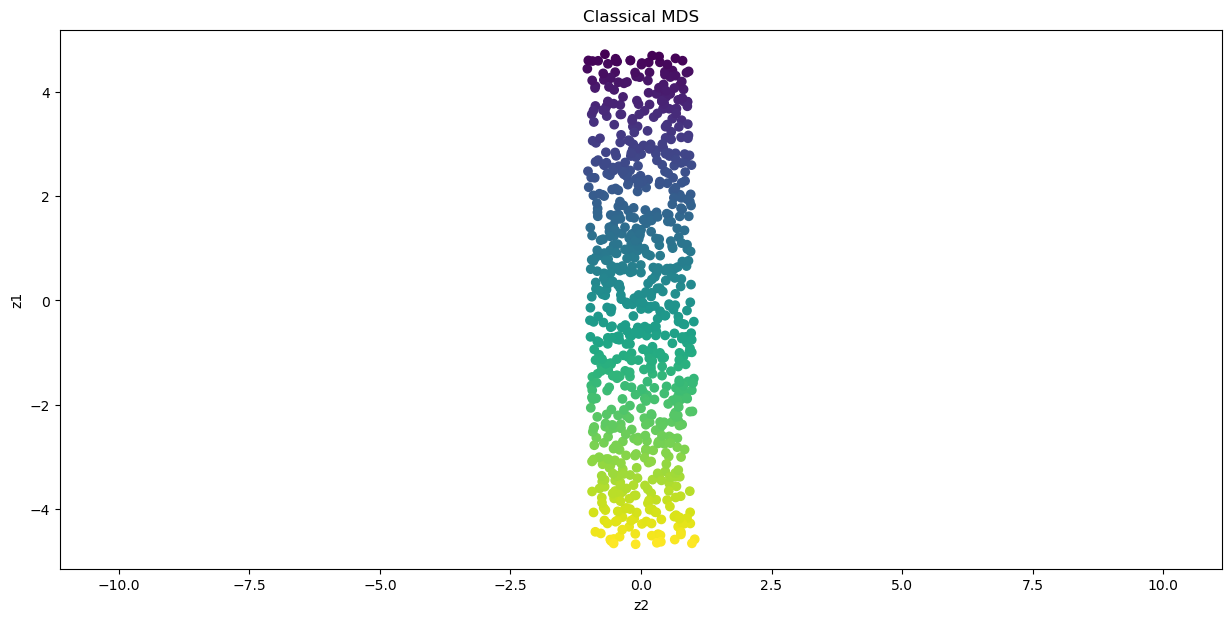

In [39]:
#===========================Fill This===========================#
# 1. Display the low dimension encoding of the data.

fig, ax    = plt.subplots(figsize= (15 , 7))

ax.scatter(X_transformed[:,1] , X_transformed[:,0] , c = vT)
ax.set_xlabel ('z2')
ax.set_ylabel ('z1')
ax.set_title('Classical MDS')

plt.axis   ('equal')
print ("")


#===============================================================#

<b>Results explanation
    
The vT returned from the make_s_curve is the location of the  points on the main axis of the mailford. 
Every point on the S curve can then be described by only two axis:  The X2 axis and the vT.
We build a distance matrix (L2)  based on these two coordinates and preform classical MDS. For classical MDS all is needed is 
to generate the Kernel matrix and preform KPCA.
    
As we realized that the meaningful distance is compounded of only from  two original dimensions  (vT is considered another dimension in this case) we can plot the points with only these two dimensions and achieve the same results.
On general if we did not have a clear view of the meaning of all dimensions including vT we could generate a distance function based on all four dimensions and tailor the dimensions weights in the distance to achieve the desired result. (In our case the weights of two our of the four dimensions are set to zero)


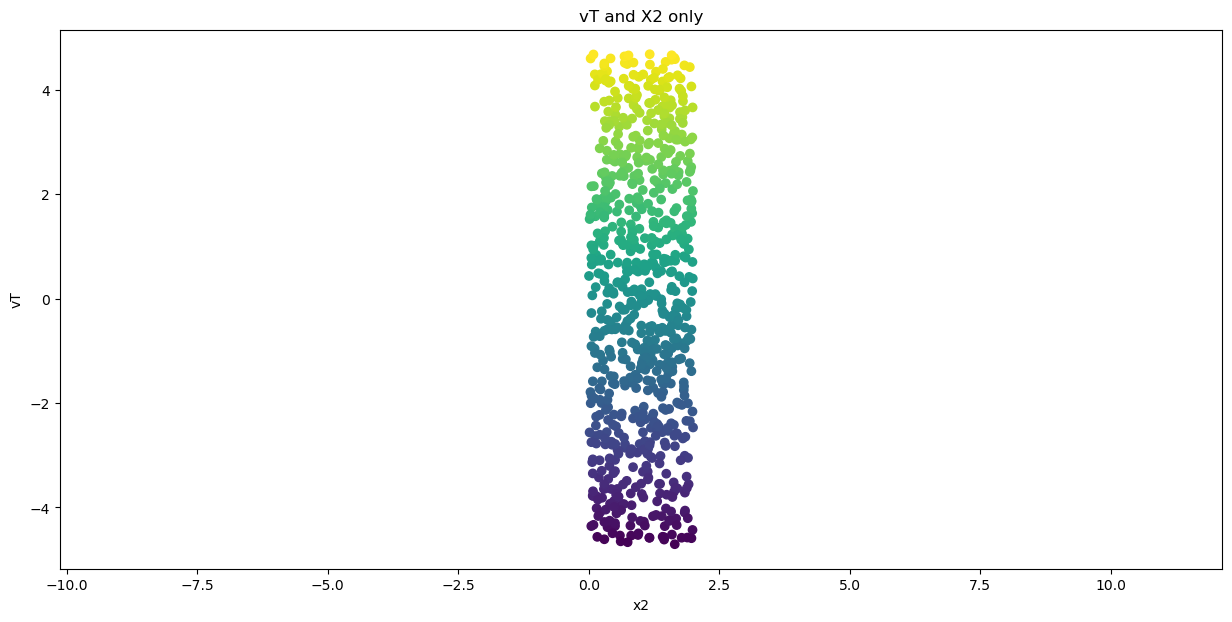

In [40]:

fig, ax    = plt.subplots(figsize= (15 , 7))

ax.scatter(mX[:,1] , vT , c = vT)
ax.set_xlabel ('x2')
ax.set_ylabel ('vT')

ax.set_title('vT and X2 only')

plt.axis   ('equal')
print ("")
